In [50]:
from openai import OpenAI
import base64
import json
from pathlib import Path
import os
from PIL import Image
from matplotlib import pyplot as plt
from io import BytesIO
import json
from pydantic import BaseModel
import pprint as pp
import numpy as np
import pickle
from scipy.interpolate import interp1d

In [2]:
# Function to open image file, resize to 512x512, and encode to base64
def encode_image(image_path):
    image = Image.open(image_path)
    # image = image.resize((512, 512))
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str
    

In [15]:

def get_b64_images(img_dir_path):
    files = os.listdir(img_dir_path)
    # sort the files by filename
    files.sort()
    #files = files[:10]
    # read each file, convert to base64 and put in an array
    images = []
    images_b64 = []
    for file in files:
        if file.endswith(".png"):
            # store the images as a PIL image in the array
            image = Image.open(os.path.join(img_dir_path, file))
            images.append(image)
            images_b64.append(encode_image(os.path.join(img_dir_path, file)))
    return images, images_b64


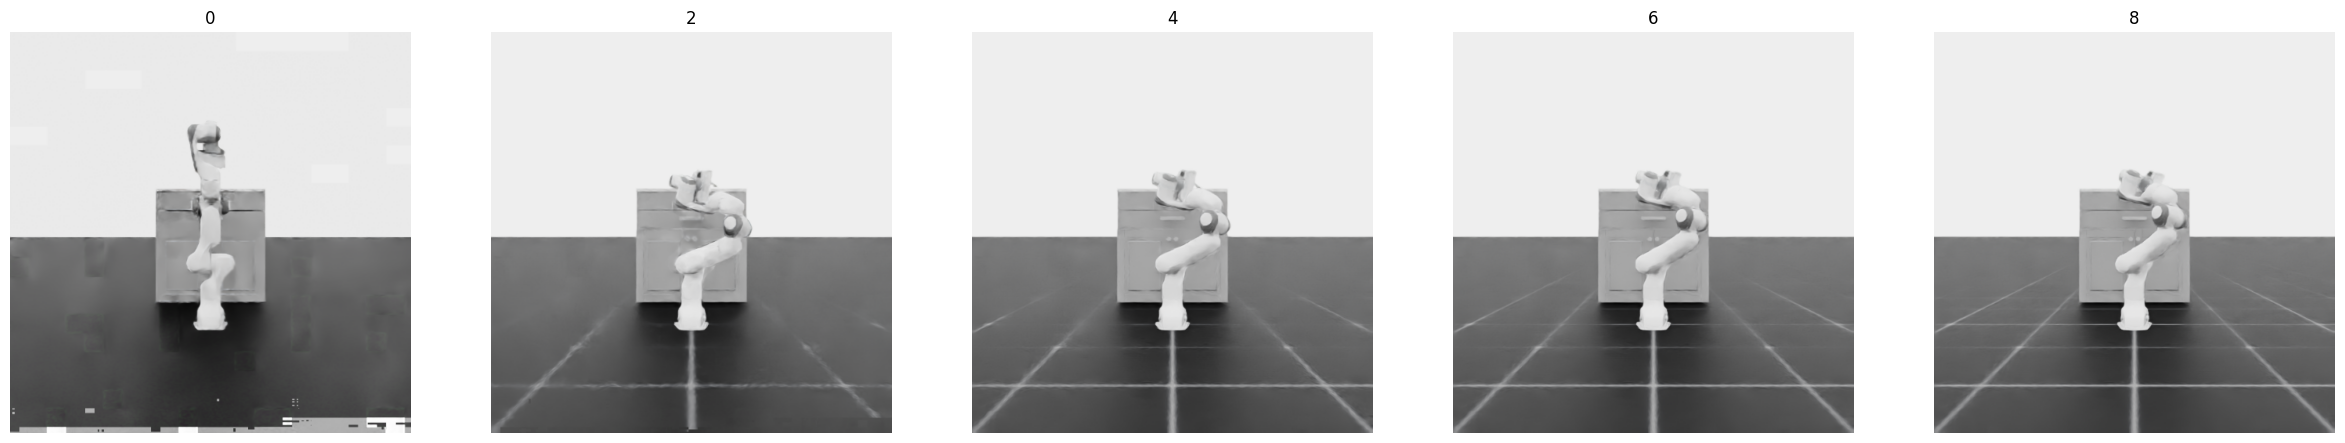

In [4]:
img_dir_path = "/home/levi/projects/IsaacLab/source/vlmrew/dev_images/p13"
images, images_b64 = get_b64_images(img_dir_path)

# plot the images in a single plot using matplotlib
img_plot_idx = list(range(0,10,2))
images_sub = [image for i, image in enumerate(images) if i in img_plot_idx]
fig, axs = plt.subplots(1, len(images_sub), figsize=(30, 30))
for i, image in enumerate(images_sub):
    axs[i].imshow(image)
    axs[i].axis("off")
    axs[i].set_title(img_plot_idx[i])

In [5]:
def get_gpt_message(ref_image_b64, eval_image_b64):
    message = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": """You are an image assessment tool that intreprets images and provides a real valued score between 0 and 10, indicating the degree that a robot has completed a specified task. 
                    A score of 0 is assigned in the initial state, and a score of 10 is assigned in the final state when the task is completed.""",
                },                   
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "A robot arm is given a task to open the top drawer of a white cabinet.",
                },          
                {
                    "type": "text",
                    "text": "A reference image of the initial state of the task is shown in the following image. The score for the reference image is 0"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{ref_image_b64}",
                        "detail": "auto",
                        },
                },
                {
                    "type": "text",
                    "text": "Provide a score for the following image.",
                },         
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{eval_image_b64}",
                        "detail": "auto",
                        },
                },
            ],
        },
    ]
    return message


In [6]:
class Score(BaseModel):
    score: float

class GPT_Rewards(BaseModel):
    scores: list[Score]

In [12]:

def get_gpt_rewards(images_b64, sample_period=30):
    api_key = os.environ.get("OPENAIKEY")
    gpt_client = OpenAI(
        api_key=api_key
    )
    ref_image_b64 = images_b64[10]
    gpt_rew = np.zeros(len(images_b64))
    # get a reward score for each of the evaluation images
    for i in range(5, len(images_b64), sample_period):
        #print(f"Evaluating image: {i}")
        eval_image_b64 = images_b64[i]
        message = get_gpt_message(ref_image_b64, eval_image_b64)
        response = gpt_client.chat.completions.create(
            model="gpt-4o-2024-08-06",
            messages=message,
            response_format={
                'type': 'json_schema',
                'json_schema':
                    {
                        "name": "whocares",
                        "schema": GPT_Rewards.model_json_schema()
                    }
            }
        )
        reward_scores = response.choices[0].message.content
        reward_array = json.loads(reward_scores)["scores"]
        score_array = [score["score"] for score in reward_array]
        gpt_rew[i] = score_array[0]
    return gpt_rew


In [106]:
# compute rewards for different points
point = "p13"
image_path = f"/home/levi/projects/IsaacLab/source/vlmrew/dev_images/" + point
images, images_b64 = get_b64_images(image_path)
gpt_rew_all = get_gpt_rewards(images_b64, sample_period=5)


In [107]:
# Read in the rewards pickle file
rewards = pickle.load(open("/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/manual_rewards.pkl", "rb"))

# scale the rewards data from 0 to 10
man_rew_norm = (rewards - np.min(rewards)) / (np.max(rewards) - np.min(rewards)) * 10
man_rew_norm = np.array(man_rew_norm)

In [108]:
gpt_rew_5_step_rate = np.array(gpt_rew_all)
gpt_rew_10_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_10_step_rate[5::10] = 0
gpt_rew_15_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_15_step_rate[5::15] = 0
gpt_rew_15_step_rate[10::15] = 0
gpt_rew_20_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_20_step_rate[5::20] = 0
gpt_rew_20_step_rate[10::20] = 0
gpt_rew_20_step_rate[15::20] = 0
gpt_rew_25_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_25_step_rate[5::25] = 0
gpt_rew_25_step_rate[10::25] = 0
gpt_rew_25_step_rate[15::25] = 0
gpt_rew_25_step_rate[20::25] = 0
gpt_rew_30_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_30_step_rate[5::30] = 0
gpt_rew_30_step_rate[10::30] = 0
gpt_rew_30_step_rate[15::30] = 0
gpt_rew_30_step_rate[20::30] = 0
gpt_rew_30_step_rate[25::30] = 0
gpt_rew_35_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_35_step_rate[5::35] = 0
gpt_rew_35_step_rate[10::35] = 0
gpt_rew_35_step_rate[15::35] = 0
gpt_rew_35_step_rate[20::35] = 0
gpt_rew_35_step_rate[25::35] = 0
gpt_rew_35_step_rate[30::35] = 0
gpt_rew_40_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_40_step_rate[5::40] = 0
gpt_rew_40_step_rate[10::40] = 0
gpt_rew_40_step_rate[15::40] = 0
gpt_rew_40_step_rate[20::40] = 0
gpt_rew_40_step_rate[25::40] = 0
gpt_rew_40_step_rate[30::40] = 0
gpt_rew_40_step_rate[35::40] = 0
gpt_rew_45_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_45_step_rate[5::45] = 0
gpt_rew_45_step_rate[10::45] = 0
gpt_rew_45_step_rate[15::45] = 0
gpt_rew_45_step_rate[20::45] = 0
gpt_rew_45_step_rate[25::45] = 0
gpt_rew_45_step_rate[30::45] = 0
gpt_rew_45_step_rate[35::45] = 0
gpt_rew_45_step_rate[40::45] = 0
gpt_rew_50_step_rate = gpt_rew_5_step_rate.copy()
gpt_rew_50_step_rate[5::50] = 0
gpt_rew_50_step_rate[10::50] = 0
gpt_rew_50_step_rate[15::50] = 0
gpt_rew_50_step_rate[20::50] = 0
gpt_rew_50_step_rate[25::50] = 0
gpt_rew_50_step_rate[30::50] = 0
gpt_rew_50_step_rate[35::50] = 0
gpt_rew_50_step_rate[40::50] = 0
gpt_rew_50_step_rate[45::50] = 0


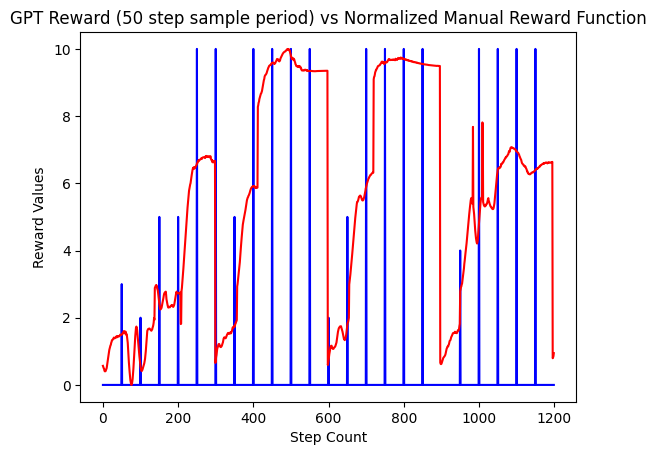

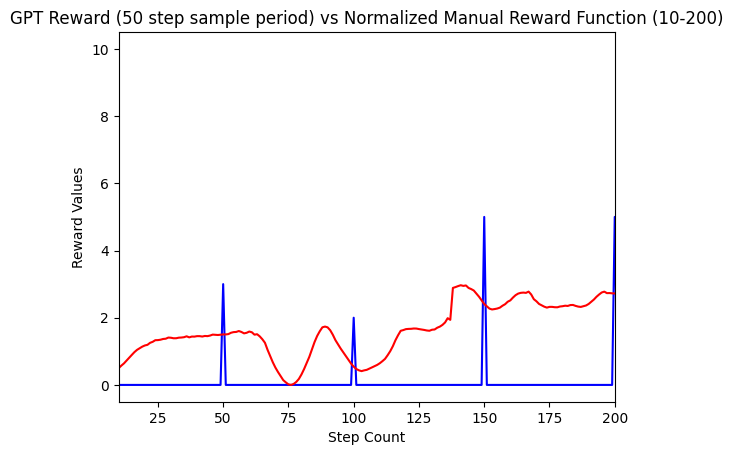

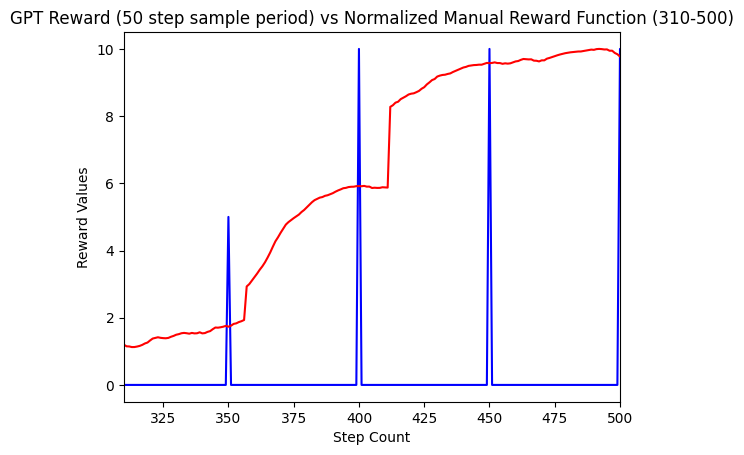

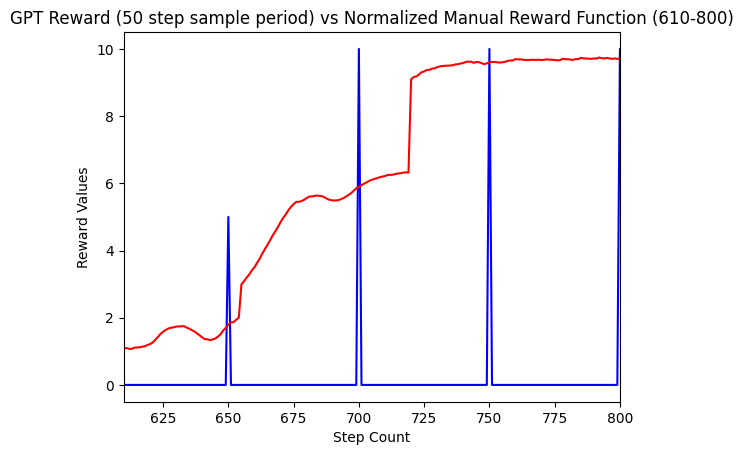

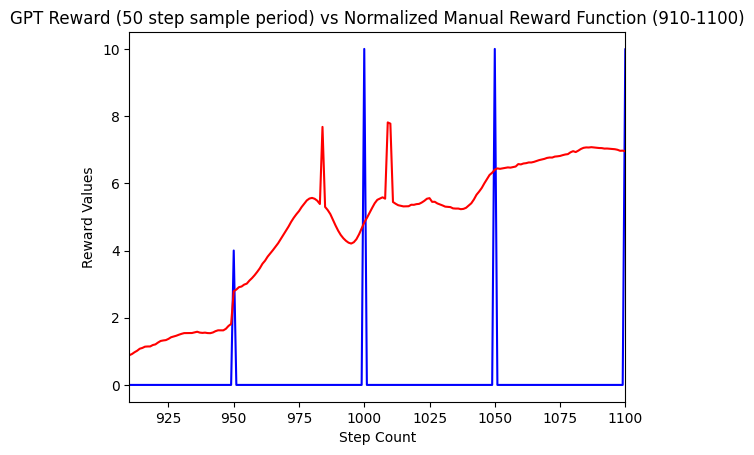

In [79]:
gpt_rew = gpt_rew_50_step_rate
rate_string = '50'

eval_range = []

# plot the rewards, the error, and the MSE error on separate plots
plt.plot(gpt_rew, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"GPT Reward ({rate_string} step sample period) vs Normalized Manual Reward Function")

# plot the zoomed in region from 300 to 400 and 600 to 700
plt.figure()
pltrange = [10,200]
plt.plot(gpt_rew, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlim(pltrange)
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"GPT Reward ({rate_string} step sample period) vs Normalized Manual Reward Function ({pltrange[0]}-{pltrange[1]})")
eval_range = eval_range + (list(range(pltrange[0], pltrange[1]+1)))

plt.figure()
pltrange = [310,500]
plt.plot(gpt_rew, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlim(pltrange)
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"GPT Reward ({rate_string} step sample period) vs Normalized Manual Reward Function ({pltrange[0]}-{pltrange[1]})")
eval_range = eval_range + (list(range(pltrange[0], pltrange[1]+1)))


plt.figure()
pltrange = [610,800]
plt.plot(gpt_rew, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlim(pltrange)
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"GPT Reward ({rate_string} step sample period) vs Normalized Manual Reward Function ({pltrange[0]}-{pltrange[1]})")
eval_range = eval_range + (list(range(pltrange[0], pltrange[1]+1)))

plt.figure()
pltrange = [910,1100]
plt.plot(gpt_rew, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlim(pltrange)
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"GPT Reward ({rate_string} step sample period) vs Normalized Manual Reward Function ({pltrange[0]}-{pltrange[1]})")
eval_range = eval_range + (list(range(pltrange[0], pltrange[1]+1)))



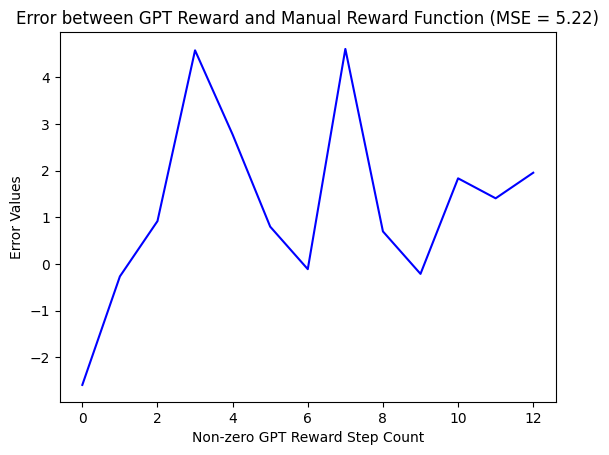

In [118]:
gpt_rew = gpt_rew_50_step_rate
# Get the error between the manual reward and the GPT reward for all gpt values above 0
error_list = [man_rew_norm[i]-gpt_rew[i] for i in eval_range if gpt_rew[i] > 0]
mse = np.mean(np.square(error_list))

# plot the error
plt.figure()
plt.plot(error_list, 'b')
plt.xlabel("Non-zero GPT Reward Step Count")
plt.ylabel("Error Values")
plt.title(f"Error between GPT Reward and Manual Reward Function (MSE = {mse:.2f})")
plt.show()

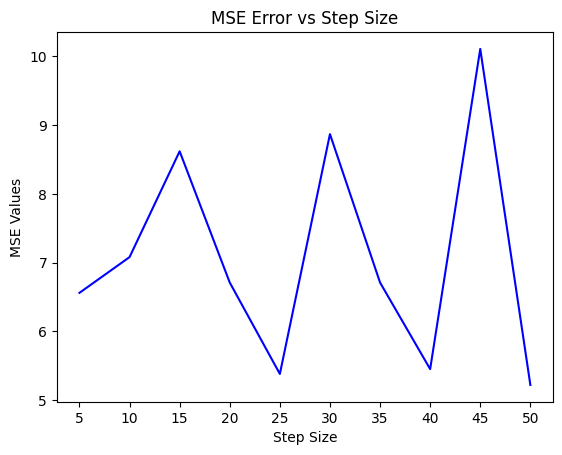

In [119]:
# for aspect p1 
#MSE_list = [7.75, 7.77, 7.39, 7.82, 8.29, 6.53, 7.96, 7.13, 8.06, 7.60]
# for aspect p13
MSE_list = [6.56, 7.08, 8.62, 6.71, 5.38, 8.87, 6.71, 5.45, 10.11, 5.22]
step_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# plot the MSE error values
plt.figure()
plt.plot(step_sizes, MSE_list, 'b')
plt.xlabel("Step Size")
plt.ylabel("MSE Values")
plt.title(f"MSE Error vs Step Size")
plt.xticks(step_sizes)
plt.show()

In [124]:

points = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13']
aspect_mse_array = np.zeros(len(points))
gpt_aspect_rew_all = np.zeros((len(points), 1200))
for j, point in enumerate(points):
    print(f"Calculating error for {point}")
    # get the index of the point    
    image_path = f"/home/levi/projects/IsaacLab/source/vlmrew/dev_images/" + point
    images, images_b64 = get_b64_images(image_path)
    gpt_aspect_rew_all[j] = get_gpt_rewards(images_b64, sample_period=5)

    

Calculating error for p1
Calculating error for p2
Calculating error for p3
Calculating error for p4
Calculating error for p5
Calculating error for p6
Calculating error for p7
Calculating error for p8
Calculating error for p9
Calculating error for p10
Calculating error for p11
Calculating error for p12
Calculating error for p13


In [125]:
# save the aspect_mse_array to a pkl file
gpt_aspect_rew_all_file_path = "/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/gpt_aspect_rew_all.pkl"
pickle.dump(gpt_aspect_rew_all, open(gpt_aspect_rew_all_file_path, "wb"))

In [126]:
mse_error = np.zeros(len(points))
for j in range(len(points)):
    mse_error[j] = np.mean(np.square(np.array([gpt_aspect_rew_all[j,i]-man_rew_norm[i] for i in eval_range if gpt_aspect_rew_all[j,i] > 0])))

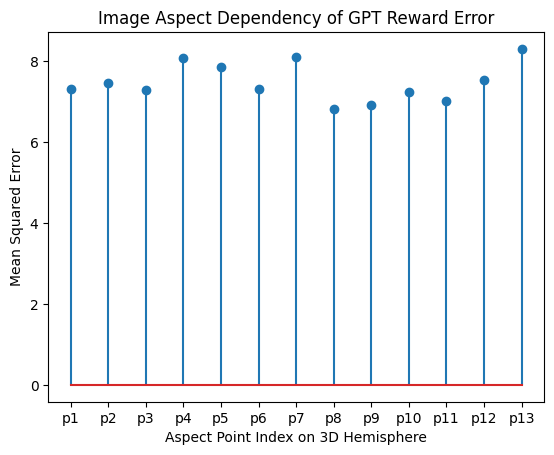

In [127]:

# Plot the aspect MSE array using a stem plot
plt.stem(mse_error)
plt.xlabel("Aspect Point Index on 3D Hemisphere")
plt.ylabel("Mean Squared Error")
plt.title("Image Aspect Dependency of GPT Reward Error")

plt.xticks(range(len(points)), points)
plt.show()


## Analyze the effect of adding more image examples to the prompt in a few-shot approach to helping ChatGPT to understand the range of values 

In [13]:
# For the fewshot directory, plot the reward for the seed=43
fewshot_dir = "/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/fewshot_rewards.pkl"
fewshot_rewards = pickle.load(open(fewshot_dir, "rb"))
# normailize the data to [0,10]
fewshot_rewards = (fewshot_rewards - np.min(fewshot_rewards)) / (np.max(fewshot_rewards) - np.min(fewshot_rewards)) * 10


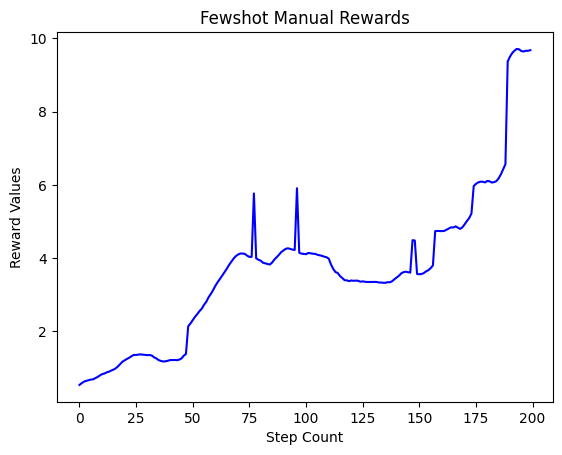

In [16]:

# plot the fewshot rewards function
plot_range = range(1500,1700)
plt.plot(fewshot_rewards[plot_range], 'b')
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"Fewshot Manual Rewards")
plt.show()

In [10]:
def get_specific_b64_images(img_path_list):
    # keep the files in the specific order supplied
    files = [f"/home/levi/projects/IsaacLab/source/vlmrew/dev_images/fewshot/franka_cabinet_image_timestep_{i}.png" for i in img_path_list]
    # For the fewshot directory, plot the reward for the seed=43
    fewshot_dir = "/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/fewshot_rewards.pkl"
    fewshot_rewards = pickle.load(open(fewshot_dir, "rb"))
    # normailize the data to [0,10]
    fewshot_rewards_norm = (fewshot_rewards - np.min(fewshot_rewards)) / (np.max(fewshot_rewards) - np.min(fewshot_rewards)) * 10
    # read each file, convert to base64 and put in an array
    reward = []
    images_b64 = []
    for i, file in enumerate(files):
        if file.endswith(".png"):
            # store the images as a PIL image in the array
            reward.append(fewshot_rewards_norm[img_path_list[i]])
            images_b64.append(encode_image(file))
    return reward, images_b64

In [42]:
class Score(BaseModel):
    score: float

class GPT_Rewards(BaseModel):
    scores: list[Score]
    
def get_few_shot_gpt_message(ref_images_b64, ref_rewards, eval_image_b64):
    message = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": """You are an image assessment tool that intreprets images and provides a real valued score between 0 and 10, indicating the degree that a robot has completed a specified task. 
                    A score of 0 is assigned in the initial state, and a score of 10 is assigned in the final state when the task is completed.""",
                },                   
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "A robot arm is given a task to open the top drawer of a white cabinet.",
                },          
                
            ],
        },
    ]

    for i in range(len(ref_rewards)):
        message[1]["content"].append(            
            {
                "type": "text",
                "text": f"To help as a reference, an example image of a single moment of the task is shown in the following image. The score for the image is {ref_rewards[i]:.1f}"
            }              
        )
        message[1]["content"].append(            
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{ref_images_b64[i]}",
                    "detail": "auto",
                    },
            }               
        )

    message[1]["content"].append(
        {
            "type": "text",
            "text": "Provide a score for the following image.",
        }
    )
    message[1]["content"].append(         
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{eval_image_b64}",
                "detail": "auto",
                },
        }
    )
    return message


In [22]:
def get_few_shot_gpt_rewards(ref_images_b64, ref_rewards, images_b64, sample_period=30):
    api_key = os.environ.get("OPENAIKEY")
    gpt_client = OpenAI(
        api_key=api_key
    )
    ref_image_b64 = images_b64[10]
    gpt_rew = np.zeros(len(images_b64))
    # get a reward score for each of the evaluation images
    for i in range(5, len(images_b64), sample_period):
        print(f"Evaluating image: {i}")
        eval_image_b64 = images_b64[i]
        message = get_few_shot_gpt_message(ref_images_b64, ref_rewards, eval_image_b64)
        response = gpt_client.chat.completions.create(
            model="gpt-4o-2024-08-06",
            messages=message,
            response_format={
                'type': 'json_schema',
                'json_schema':
                    {
                        "name": "whocares",
                        "schema": GPT_Rewards.model_json_schema()
                    }
            }
        )
        reward_scores = response.choices[0].message.content
        reward_array = json.loads(reward_scores)["scores"]
        score_array = [score["score"] for score in reward_array]
        gpt_rew[i] = score_array[0]
    return gpt_rew


In [72]:
ref_image_index_list = [1501, 1525, 1550, 1575, 1600, 1625, 1650, 1675, 1700]
ref_rewards, ref_images_b64 = get_specific_b64_images(ref_image_index_list)

In [73]:
# compute rewards for different points
point = "p7"
image_path = f"/home/levi/projects/IsaacLab/source/vlmrew/dev_images/" + point
images, images_b64 = get_b64_images(image_path)
gpt_rew_all = get_few_shot_gpt_rewards(ref_images_b64, ref_rewards, images_b64, sample_period=15)

Evaluating image: 5
Evaluating image: 20
Evaluating image: 35
Evaluating image: 50
Evaluating image: 65
Evaluating image: 80
Evaluating image: 95
Evaluating image: 110
Evaluating image: 125
Evaluating image: 140
Evaluating image: 155
Evaluating image: 170
Evaluating image: 185
Evaluating image: 200
Evaluating image: 215
Evaluating image: 230
Evaluating image: 245
Evaluating image: 260
Evaluating image: 275
Evaluating image: 290
Evaluating image: 305
Evaluating image: 320
Evaluating image: 335
Evaluating image: 350
Evaluating image: 365
Evaluating image: 380
Evaluating image: 395
Evaluating image: 410
Evaluating image: 425
Evaluating image: 440
Evaluating image: 455
Evaluating image: 470
Evaluating image: 485
Evaluating image: 500
Evaluating image: 515
Evaluating image: 530
Evaluating image: 545
Evaluating image: 560
Evaluating image: 575
Evaluating image: 590
Evaluating image: 605
Evaluating image: 620
Evaluating image: 635
Evaluating image: 650
Evaluating image: 665
Evaluating image: 

In [45]:
# Read in the rewards pickle file
rewards = pickle.load(open("/home/levi/projects/IsaacLab/source/vlmrew/franka_cabinet/logs/manual_rewards.pkl", "rb"))

# scale the rewards data from 0 to 10
man_rew_norm = (rewards - np.min(rewards)) / (np.max(rewards) - np.min(rewards)) * 10
man_rew_norm = np.array(man_rew_norm)



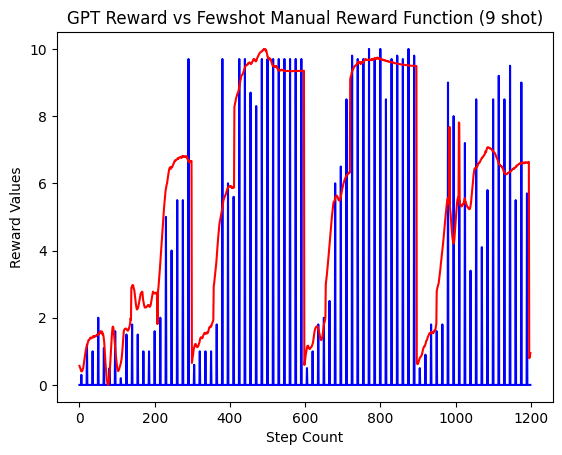

In [74]:
# plot the gpt rewards
plt.plot(gpt_rew_all, 'b')
plt.plot(man_rew_norm, 'r')
plt.xlabel("Step Count")
plt.ylabel("Reward Values")
plt.title(f"GPT Reward vs Fewshot Manual Reward Function (9 shot)")
plt.show()